## Introduction 

I'm delving into the world of data engineering and machine learning, using data from a personal Spotify account. The dataset I'm working with consists of 10,000 data points, representing my listening history from the past year. This dataset includes:


- **endTime**: The date and time, recorded in UTC, when I stopped listening to a particular song.
- **trackName**: The song's name.
- **artistName**: The artist's name.
- **msPlayed**: how long I played the song before ending or changing it in milliseconds

I hypothesize that I listen to different types of music depending on the day of the week. I beleive that Mondays are more work focussed days, Fridays are more party songs and Sundays are more church focussed. This is just a hunch so I want to see if machine learning can classify the day of the week I was listening to a song based on the other features in the dataset. From this I might be able to find patterns in the music content I consume on certain days and change my listening habits on days I tend to feel less great. 

The data was obtained from my personal Spotify account and as sent to me directly from Spotify as a document of json objects. 

Before we begin the analysis we need to load and visualize the spotify data.

## Loading the Data
The data was obtained from my personal Spotify account in a document called "StreamingHistory0.json" and was sent to me directly from Spotify as a document of json objects. I simply loaded the document and converted is to a CSV file. 

In [425]:
#Import all necessary modules and packaged 

def load_dependencies():

    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.preprocessing import LabelEncoder, StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
    from imblearn.over_sampling import RandomOverSampler
    from sklearn.ensemble import RandomForestClassifier

    import pandas as pd
    import json
    import csv
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

load_dependencies()

**Importing the data**

In [400]:
def import_data():
    name = 'StreamingHistory0.json'
    # Load JSON data from a file
    with open(name, 'r') as json_file:
        data = json.load(json_file)

    # Specify the output CSV file name
    csv_filename = 'output.csv'

    # Open the CSV file in write mode
    with open(csv_filename, 'w', newline='') as csv_file:
        # Create a CSV writer object
        csv_writer = csv.writer(csv_file)

        # Write the header row based on the keys in the JSON data
        header = data[0].keys()
        csv_writer.writerow(header)

        # Write the data rows
        for row in data:
            csv_writer.writerow(row.values())

    print(f'JSON data has been successfully converted to {csv_filename}')

import_data()  

JSON data has been successfully converted to output.csv


In [401]:
def make_df():
    name = 'output.csv'
    df = pd.read_csv(name)
    return df

print(make_df().head())


            endTime     artistName                       trackName  msPlayed
0  2022-10-06 14:18  Adekunle Gold                             FYE    150278
1  2022-10-06 14:42  Adekunle Gold                             FYE    167400
2  2022-10-07 06:09     Ayra Starr                            Rush    185093
3  2022-10-07 06:12     Ayra Starr                Bloody Samaritan    187000
4  2022-10-07 06:15         Magixx  Love Don't Cost A Dime (Re-Up)    147600


## Preprocessing the data

**Day and Date**

I want to predict the day of the day of the week so I will split the "endTime" column into a Time and Day column and discard the date. Remove the date so that the model does not simply start calculating the day of the week based on the date (which would be a very easy task to do). 

**Remove duplicates**

There are also many repetitions of songs that I want to remove. This is to make accuracy scores easier and more accurate. For example if a song was played on Monday, Tuesday and Wednesday then I would either have to build the model to predict all the possible days and assign it a score based on the percentage of days it guessed correctly or I would let predict just one of the days and decide if I consider that correct or if I give a $1/3$ of a score for guessing just one day. 

Ultimately I remove duplicates solve this issue. Notably by removing duplicates the size of the dataset reduces from $10,000$ to $3307$.  

In [402]:
def preprocess():
    
    df = make_df()
    # Remove duplicates based on specific columns
    df = df.drop_duplicates(subset=['trackName'])

    #Convert the "Date" column to a datetime object
    df["endTime"] = pd.to_datetime(df["endTime"])

    # Extract the day of the week and create a new "Day" column
    df["Day"] = df["endTime"].dt.strftime("%A")

    # Extract the time and create a new "Time" column
    df["Time"] = df["endTime"].dt.strftime("%H:%M")

    #change time from a string to a decimal 
    df['endTime'] = pd.to_datetime(df['endTime'], format='%H:%M')

    # Calculate the time in decimal format
    df['Time'] = df['endTime'].dt.hour + df['endTime'].dt.minute / 60.0

    #drop the endTime feature containing the date
    df = df.drop(columns=["endTime"])

    return df, "data preprocessed"
    
preprocess()

(         artistName                       trackName  msPlayed       Day  \
 0     Adekunle Gold                             FYE    150278  Thursday   
 2        Ayra Starr                            Rush    185093    Friday   
 3        Ayra Starr                Bloody Samaritan    187000    Friday   
 4            Magixx  Love Don't Cost A Dime (Re-Up)    147600    Friday   
 5      ElGrandeToto    Comforter (feat. Ayra Starr)    216000    Friday   
 ...             ...                             ...       ...       ...   
 9964   Stefflon Don                   What's Poppin    195426  Saturday   
 9968           Tyla                         To Last    176283  Saturday   
 9969        Doechii                      60 Seconds     34252  Saturday   
 9970    Xavier Omär                       want/need       766  Saturday   
 9971           Bnxn                  Loose Emotions      8707  Saturday   
 
            Time  
 0     14.300000  
 2      6.150000  
 3      6.200000  
 4      6.

## Data Exploration 

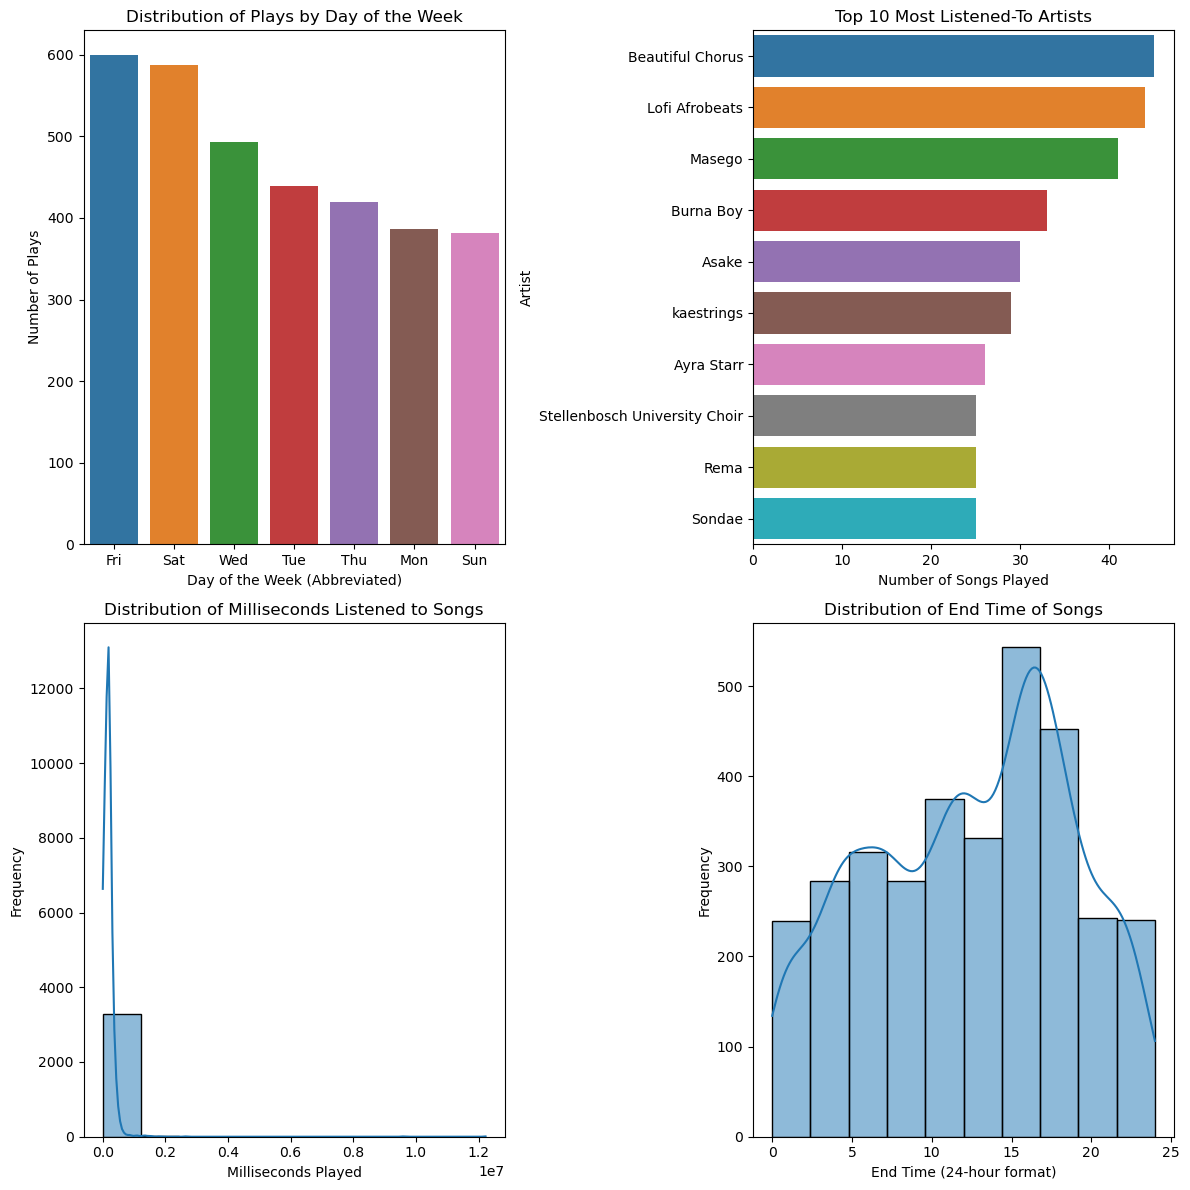

In [367]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = preprocess()[0]

# Create a figure with two columns and two rows
plt.figure(figsize=(12, 12))

# Subplot 1: Distribution of plays by day of the week
plt.subplot(221)
day_order = df['Day'].value_counts().index
sns.countplot(data=df, x='Day', order=day_order)
plt.xlabel('Day of the Week (Abbreviated)')
plt.ylabel('Number of Plays')
plt.title('Distribution of Plays by Day of the Week')
plt.gca().set_xticklabels([d[:3] for d in day_order])

# Subplot 2: Top listened-to artists
plt.subplot(222)
top_artists = df['artistName'].value_counts().head(10)
sns.barplot(x=top_artists.values, y=top_artists.index, orient='h')
plt.xlabel('Number of Songs Played')
plt.ylabel('Artist')
plt.title('Top 10 Most Listened-To Artists')

# Subplot 3: Distribution of milliseconds listened to songs
plt.subplot(223)
sns.histplot(data=df, x='msPlayed', bins=10, kde=True)
plt.xlabel('Milliseconds Played')
plt.ylabel('Frequency')
plt.title('Distribution of Milliseconds Listened to Songs')

# Subplot 4: Distribution of end time
plt.subplot(224)
sns.histplot(data=df, x='Time', bins=10, kde=True)
plt.xlabel('End Time (24-hour format)')
plt.ylabel('Frequency')
plt.title('Distribution of End Time of Songs')

plt.tight_layout()
plt.show()


As we see above the days of the week are nt very balanced as I listen to a lot  more songs on Fridays and Saturdays. I will fix this in the training of my model where I use the Synthetic Minority Oversampling Technique (SMOTE) to randomly generate extra data points for the minority classes. 

## Text Data Encoding

Now I needed to decide how to encode text data from strings to a format useful for the model. Options included some method of vectorization or "Bag of Words" type encoding. The issue is that this results in alargely meaningless and very sparse vectors because an artists name only shows up in the tracks they sang and does not show up in many other songs. When I tried to do this the vocabulary of the TF-IDF encoding was huge and very few artist names were repeated.

As a result I decided to use a dummy encoder (pandas' get_dummiesI which returns a binary column for each artist name and gives it a one if the artist's name is mentioned and 0 otherwise. 

**AristName and Featured Artists**

The trackNames included the names of the featured arists for example one entry is: 


**5 |  2022-10-07 06:18 |  ElGrandeToto  |  Comforter (feat. Ayra Starr) |   216000**

and "Comforter (feat. Ayra Starr)" is the trackName so I will remove the featured artists from the track name and add them to a list inside the artistName column. 

After that I apply **pandas' getdummy** to turn the artist names into a binary columns where the column = 1 if the artist is in the song and 0 otherwise. 

**trackName**

With the trackName I thought there was a greater opportunity for TF-IDF encoding however I quicky discovered that words are not repeated that often leading to pretty meaningless vectors. Below is code shwoing how frequently words shoed up in the trackName field and how many words showed up with said frequency. The visualization shows almsot 2000 words (66%) show up just one. Instead I just encoded the trackName according to how long it is in characters. I rengonize this is a very simplistic way to encode the data and makes it largely meaningless, however most times track names are very long because they include long strings of featured artists- therefore the length can tell me *something* about the data allbeit very limited. In the future I may want to implement a sentiment value to each trackName.



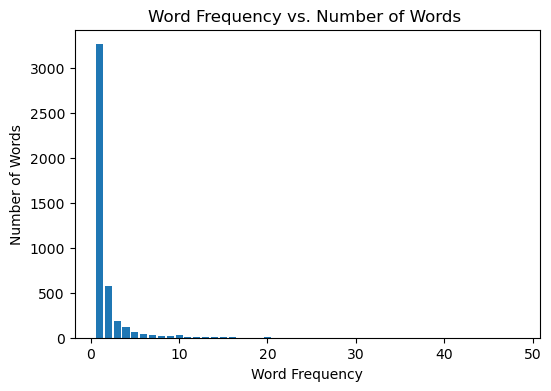

In [396]:
"""
Code showing that most words appear only once in TrackNames
"""

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

df = preprocess()[0]

# Tokenize and count words in the "trackName" field
all_words = " ".join(df["trackName"]).split()
word_counts = Counter(all_words)

# Count the number of words that appeared with each frequency
frequency_counts = Counter(word_counts.values())

# Create lists for frequencies and their corresponding counts
frequencies, counts = zip(*frequency_counts.items())

# Sort the lists by frequency
frequencies, counts = zip(*sorted(zip(frequencies, counts)))

# Limit the visualization to show frequencies up to 50
limit = 50
limited_frequencies = [f for f in frequencies if f <= limit]
limited_counts = [counts[frequencies.index(f)] for f in limited_frequencies]

# Create a bar chart to visualize the word frequency and count
plt.figure(figsize=(6, 4))
plt.bar(limited_frequencies, limited_counts)
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.title('Word Frequency vs. Number of Words ')
plt.show()



**Extracting featured Artists from track Names**

In [403]:
import pandas as pd

def extract_featured():
    
    df = preprocess()[0]

    # Extract featured artist names from the 'trackName' and add them to 'artistName' as a list
    df['featuredArtists'] = df['trackName'].str.extract(r'feat\.\s(.*$)',
                                                        expand=False).str.split(' & |, |\sand')

    # Fill missing values with an empty list
    df['featuredArtists'].fillna('', inplace=True)

    # Combine 'artistName' and 'featuredArtists' into a list
    df['artistName'] = [([artist] + featured) if featured else [artist] 
                        for artist, featured in zip(df['artistName'], df['featuredArtists'])]

    # Drop the 'featuredArtists' column
    df.drop(columns=['featuredArtists'], inplace=True)

    return df, df['artistName']

print(extract_featured()[1].head())


0                [Adekunle Gold]
2                   [Ayra Starr]
3                   [Ayra Starr]
4                       [Magixx]
5    [ElGrandeToto, Ayra Starr)]
Name: artistName, dtype: object


**Get Dummy Columns for artistName**

In [404]:
import pandas as pd

def dummify():
    
    df = extract_featured()[0]
    # Remove closing bracket from 'artistName' column
    df['artistName'] = df['artistName'].str[0].str.replace(r'\s*\(.+?\)$', '', regex=True)

    # Flatten the 'artistName' column
    df = df.explode('artistName')

    # Apply one-hot encoding to the flattened 'artistName' column
    df = pd.get_dummies(df, columns=['artistName'], prefix='artist')

    # Create a new column 'trackName_length' containing the length of each track name
    df['trackName_length'] = df['trackName'].apply(len)

    return df
    
print(dummify().head(5))

                        trackName  msPlayed       Day   Time  artist_.Sinh  \
0                             FYE    150278  Thursday  14.30             0   
2                            Rush    185093    Friday   6.15             0   
3                Bloody Samaritan    187000    Friday   6.20             0   
4  Love Don't Cost A Dime (Re-Up)    147600    Friday   6.25             0   
5    Comforter (feat. Ayra Starr)    216000    Friday   6.30             0   

   artist_.clouds  artist_0d  artist_121SELAH  artist_1K Phew  \
0               0          0                0               0   
2               0          0                0               0   
3               0          0                0               0   
4               0          0                0               0   
5               0          0                0               0   

   artist_1da Banton  ...  artist_steezy prime  artist_sxxnt.  \
0                  0  ...                    0              0   
2         

## Discussing the Task 
In this problem I want to classify a song by the day of the week I was listening to it. I use a Logistic Regressiona and Random Forest Classifier to complete this classification. Below is code showing the steps to split my data, dropping unnecessary columns and resampling the data to make it balanced.

In [ ]:
def split_data()
    # Load your data
    data = dummify()

    # Prepare the features and target drop the repeated column trackName
    X = data.drop(['Day', 'trackName'], axis=1)
    y = data['Day']

    # Normalize or scale numeric features
    scaler = StandardScaler()
    X[['msPlayed', 'Time']] = scaler.fit_transform(X[['msPlayed', 'Time']])

    # Compute the target count for oversampling
    oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)

    # Split data into features (X) and target (y) using resampled data
    X = X_resampled
    y = y_resampled

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    

## Logistic Regression 

I will train the model using first a logistic regression classifier. 
When we apply softmax in logistic regression the inputs will be the dot product of the weight vector(w) and the input vector(x) plus a bias(b) term (w.x + b).

For multiclass classification we start by computing a dot product of a weight vector and the input vector plus a buas term 

$$
\text{Input} = z =  \vec{W} \cdot \vec{x} + \text{bias}
$$



We then apply the softmax function the input vector to get probability values for each class (day of the week) the softmax function is given by : 

$$\sigma(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{k} e^{z_j}}$$

where  $z_i$ is the i-th component of the vector $z$ (ie. $\vec{W}\vec{x} + \text{b}$).

$e$ is the base of the natural logarithm

The denominator is the sum of the exponentials of all components of $z$ ie $\vec{W}\vec{x} + \text{b}$, 

This transformation ensures that the outputs represent a probability distribution over the 
k classes, where each element is the probability of the input belonging to that class.

We turn this vector into a one-hot vector where the class with the highest probability is give the value 1 and all other classes are zero.

**Loss Function**

I will start off by explaining how we get to the cross-entropy loss LCE for the binary classification example.
In binary classification we the MLE of the Bernouille distribution to get $P(y|x)$ 

where 

$$
P(y|x) = \hat{y}^y \cdot (1 - \hat{y})^{1-y}
$$

where $\hat{y}$ is the predicted y-value (probability of the test sample being in a particualr class) 

$y$ is the actual y value (either 1 or 0).

Now, we apply the natural logarithm (log) to both sides:

$$
\log\left(P(y|x)\right) = \log\left(\hat{y}^y \cdot (1 - \hat{y})^{1-y}\right)
$$

simplify: 

$$
\log\left(P(y|x)\right) = y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y})
$$


we use the fact that: 

$$
\log(ŷ) = \log(\sigma(Wx + b))
$$

The result is a log-likelihood that needs to be maximized, but we need to get the loss function that wants to be minimized. For getting the loss function, what we only need to do is to add a negative sign in front of the equation.

When we apply the value of $ŷ = σ(Wx + b)$ and then add up the losses for every class and express the equation as cross-entropy loss LCE, we will get:

$$
L_{CE} =y \log(\hat{y}) + (1 - y) \log(1 - \hat{y})
$$

Now we need to generalize this to the Multinomial Case. The equation is the same except we need to add all the values of every class.

$$
L_{CE} = -\sum_{i=1}^{k} \left(y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right)
$$


where  $k$ = the index of the class

$y_i$ is the correct label for that class (either 1 or 0)

$\hat{y}_i$ is the prediction for that class (probability between 0 and 1)


If c is the correct class, where $yc = 1$, the right side is gone leaving us with: 

$$
L_{CE} = -\sum_{i=1}^{k} \left(y_i\log(\hat{y}_i)\right) 
$$

$$
L_{CE} = - \log({\hat{y}_c)} 
$$

Using the formula for a predicted y which we mention above. 

$$ L_{CE} = -\log\frac{e^{z_i}}{\sum_{j=1}^{k} e^{z_j}}$$

For all training samples the loss function will be:


$$-\sum_{i=1}^{N} \sum_{k=1}^{K} 1[y_i = k]\log\frac{e^{z_i}}{\sum_{j=1}^{k} e^{z_j}} $$

To solve this loss function the scikitLinearRegression module uses the Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS) which is memory-efficient gradient-based optimization function. While I will now explain it in its entirety, on a high level the L-BFGS starts with an initial parameter guess, computes a graident, uses an approximation of the Hessian matrix to adjust step size and then adjusts parameters. 



## Performance: Logistic Regression

In [298]:

split_data()

# Logistic Regression Model increased max iter to ensure we converge to a resul 
model = LogisticRegression(max_iter=10000)

# K-Fold Cross-Validation
k = 10  # Adjust the number of folds as needed
cross_val_scores = cross_val_score(model, X_train, y_train, cv=k)

# Model Evaluation
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Cross-Validation Scores:", cross_val_scores)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


Cross-Validation Scores: [0.43262411 0.47163121 0.43262411 0.45744681 0.39716312 0.46099291
 0.39361702 0.44326241 0.41134752 0.46808511]
Accuracy on Test Set: 0.43059490084985835

Confusion Matrix:
[[71  1 23  8  2  4 14]
 [16 19 26  9  3  4  9]
 [29  8 39  7  6  6 15]
 [18  3 16 74  2  2  8]
 [20  5 22  6 20  4 12]
 [21  3 14  4  2 24 10]
 [11  2 13  7  2  5 57]]

Classification Report:
              precision    recall  f1-score   support

      Friday       0.38      0.58      0.46       123
      Monday       0.46      0.22      0.30        86
    Saturday       0.25      0.35      0.30       110
      Sunday       0.64      0.60      0.62       123
    Thursday       0.54      0.22      0.32        89
     Tuesday       0.49      0.31      0.38        78
   Wednesday       0.46      0.59      0.51        97

    accuracy                           0.43       706
   macro avg       0.46      0.41      0.41       706
weighted avg       0.46      0.43      0.42       706



### Plot results from the trained model

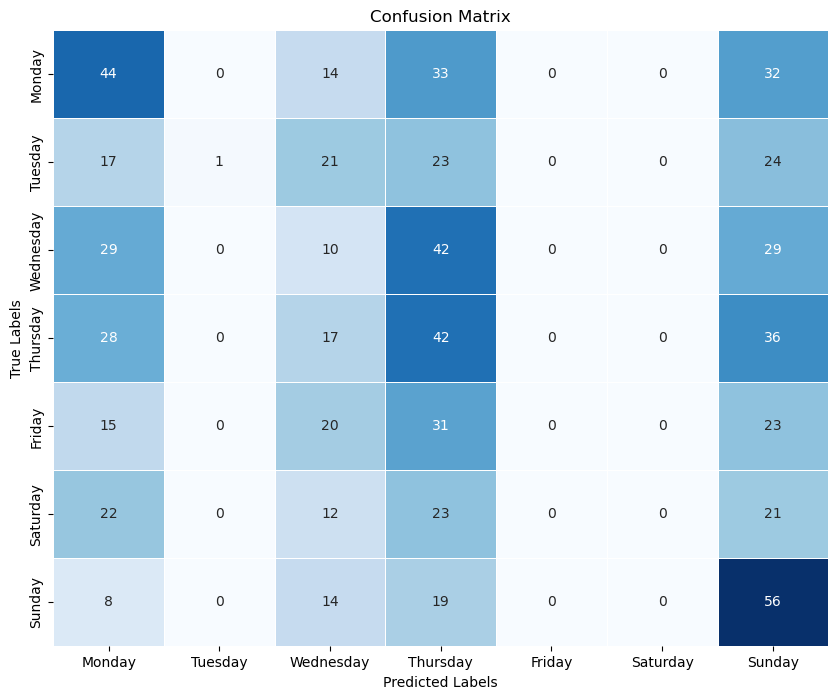

In [67]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Define the class labels (days of the week)
class_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a heatmap for visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=.5, 
            cbar=False, xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()


**Results summary**


The model's performance was evaluated using cross-validation scores, accuracy on the test set, a confusion matrix, and a classification report.

1. **Cross-Validation Scores:** The model's cross-validation scores ranged between approximately 0.397 and 0.471, indicating some variance in performance across different folds, with an accuracy of 43% on the text set. 

2. **Accuracy on Test Set:** The model achieved an accuracy of approximately 43.06% on the test set. This metric reflects the proportion of correctly classified instances.

3. **Confusion Matrix:** The model's performance varies across different days of the week. For example, it demonstrated higher precision and recall on Wednesday and Sunday but lower performance on Monday and Thursday.


Overall, the model's performance appears to be somewhat inconsistent across different days of the week. While it achieved an accuracy of approximately 43.06% on the test set, its precision and recall metrics vary for each day, indicating that it may excel in classifying certain days but struggle with others. Further analysis and potentially model tuning may be necessary to improve its overall performance.

## Random Forest classifier 

A Random Forest classifier combines the predictions of multiple decision trees to make robust and accurate classifications. It trains a multitude of decision trees on random subsets of the training data and features, and then averages their predictions. 

The scikit learn implementation of a randomforest tree includes these default configurations 

class sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, min_density=None, compute_importances=None)

Below is some pseudocode describing the process that random forest classifiers take, followed by a short paragraph description. 


    FOREST = []

    FOR TREE IN NUMBER OF TREES: 
        TREE_DATA = random choice of features and data 
        FOREST.append(BUILD_TREE(TREE_DATA))
        
        


    FUNCTION BUILD_TREE(node, features, data):
    
        WHILE TERMINATION CONDITION NOT MET: 

        LEFT = SPLIT data on CHOOSE_FEATURE_TO_SPLIT_ON(features)
        RIGHT = SPLIT data on CHOOSE_FEATURE_TO_SPLIT_ON(features)

        BUILD_TREE(LEFT, features, data)
        BUILD_TREE(RIGHT, features, data)
    
      return node


    FUNCTION CHOOSE_FEATURE_TO_SPLIT_ON(features):

        selected_feature = null
        lowest_gini_impurity = infinity

        FOR feature IN features:
            thresholds = SPLIT_ON_FEATURE(feature)

            FOR threshold IN thresholds:
                gini_impurity = COMPUTE_GINI_IMPURITY(data, feature, threshold)
                IF gini_impurity < lowest_gini_impurity:
                    lowest_gini_impurity = gini_impurity
                    selected_feature = feature
                    selected_threshold = threshold

        return selected_feature, selected_threshold
        

    FUNCTION SPLIT_ON_FEATURE(feature): 
    
        values = SORT feature values in ascending order
        thresholds = [average of adjacent feature values]
        return thresholds
        
        

    FUNCTION COMPUTE_GINI_IMPURITY(data, feature, threshold):
    
        Gini_impurity = []

        split1 = [x for x in data if x[feature] < threshold]
        split2 = [x for x in data if x[feature] > threshold]

        FOR leaf IN [split1, split2]:
            square_probability = 0

            FOR class IN classes: 
                square_probability += (COUNT(class) / LENGTH(leaf)) ** 2

            Gini_impurity.append(1 - square_probability)

        RETURN WEIGHTED_AVERAGE(Gini_impurity)

    
(this pseudocode was written from scratch without the help of any LLM's, the process was painful but I think I kind of understand how to built a random forest now)
    
    
In summary this pseudocode describes the process of building a random trees classifier we decide ona. number of trees to build and use a random subset of our data and features to build the tree on. The process of building a tree starts with choosing the most optimal feature to split on by computing the Gini impurity of the leaves resulting from a split based on that feature. For numerical features we also have to choose the best threshold to split on by iteratively computing the Gini impurities of the leaves based on a split on that feature and each threshold. After we have computed the lowest Gini Impurity of every feature we will do the first split on the feature with the lowest impurity. 

We continue this process with each resulting leaf until we reach a termination condition. For each leaf if the gini impurity = 0 we stop splitting and in default the scikit learn implementation the min_samples_split=2 is the other condition. We need a minimum of 2 samples in a node to continue splitting. 

Below we run the random_forest classifier with the default parameters from scikitlearn. 


## Performance Random Forest Classifier

Cross-Validation Scores: [0.5141844  0.53900709 0.56737589 0.5212766  0.5070922  0.57092199
 0.4822695  0.5070922  0.5        0.54964539]
Accuracy on Test Set: 0.5439093484419264

Confusion Matrix:
[[72  1 19  5  7  7 12]
 [ 7 31 13  5  5 12 13]
 [11  7 60  5  9 10  8]
 [ 2  1 11 99  2  3  5]
 [ 4  8 13  8 31 15 10]
 [ 9  4 14  5  2 38  6]
 [ 9  3 15  6  5  6 53]]

Classification Report:
              precision    recall  f1-score   support

      Friday       0.63      0.59      0.61       123
      Monday       0.56      0.36      0.44        86
    Saturday       0.41      0.55      0.47       110
      Sunday       0.74      0.80      0.77       123
    Thursday       0.51      0.35      0.41        89
     Tuesday       0.42      0.49      0.45        78
   Wednesday       0.50      0.55      0.52        97

    accuracy                           0.54       706
   macro avg       0.54      0.53      0.52       706
weighted avg       0.55      0.54      0.54       706



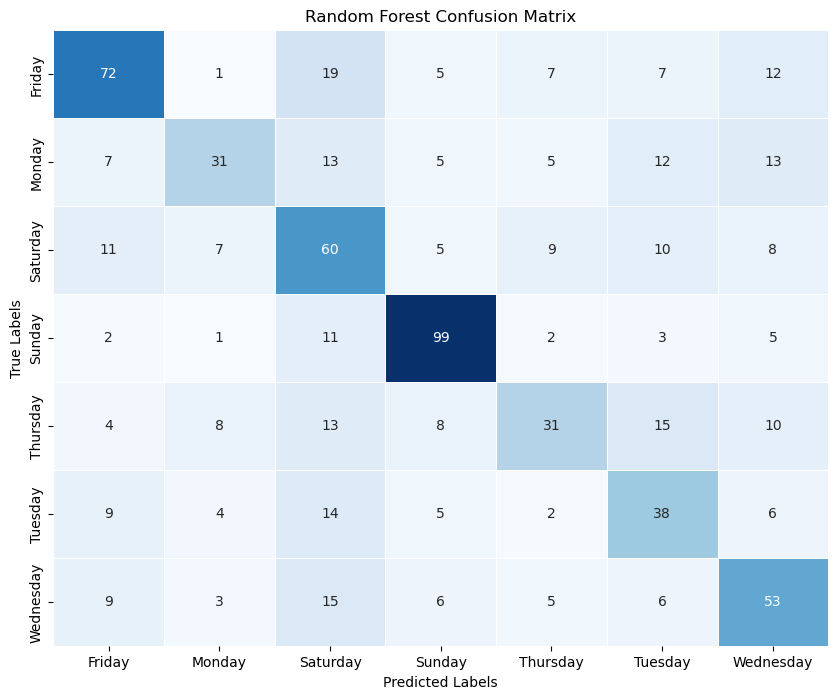

None


In [413]:
 def random_forest(max_depth= None, min_samples_split= 2, n_estimators=10):
        
    # Load your data
    data = dummify()

    # Prepare the features and target
    X = data.drop(['Day', 'trackName'], axis=1)
    y = data['Day']

    # Normalize or scale numeric features
    scaler = StandardScaler()
    X[['msPlayed', 'Time']] = scaler.fit_transform(X[['msPlayed', 'Time']])

    # Compute the target count for oversampling
    oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)

    # Split data into features (X) and target (y) using resampled data
    X = X_resampled
    y = y_resampled

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Random Forest Classifier Model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # K-Fold Cross-Validation
    k = 10  
    cross_val_scores = cross_val_score(rf_model, X_train, y_train, cv=k)

    # Model Evaluation
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)


    print("Cross-Validation Scores:", cross_val_scores)
    print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Calculate the distribution of days in the test set
    test_day_counts = y_test.value_counts()

    # Generate a confusion matrix heatmap
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_labels = sorted(y_test.unique())

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                linewidths=.5, cbar=False, xticklabels=class_labels, yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Random Forest Confusion Matrix')
    plt.show()
    
print(random_forest())

From the above we see that the accuracy on the test set is higher at 54%. However we still have varying results, the F1 score for Friday's and Sundays is much higher possibly due to the larger number if data points in the test set. The model is still pretty poor at predicting other days of the week. 

### Implement ROC curve code : One versus Rest 
The scikit-learn implementation for ROC curves is built to binary classifications. As a result I had to implement a one versus rest implementation. In this case the TPR, FPR are computed by taking one class label at a time and making that the postive case and the sum of all the other labels is the negatie case. Important to note here that the unbalanced nature of this implementation had cause some issues. 



In [301]:
#variables needed to build the ROC curves 
rf_y_pred = y_pred
rf_y_proba = rf_model.predict_proba(X_test)
classes = rf_model.classes_


In [302]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [303]:
#get the coords of the roc curve 
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [304]:
#plot rocs curve from the coords 
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

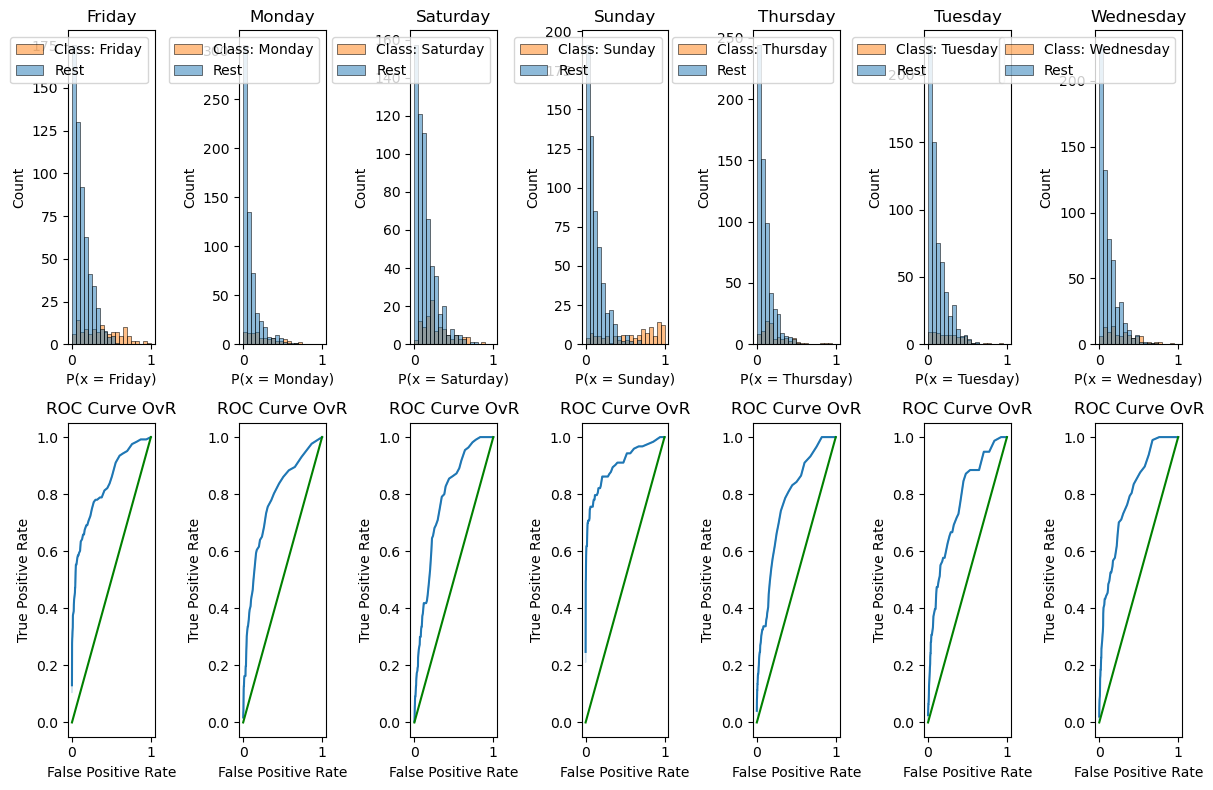

In [88]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = rf_y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 7, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 7, i+8)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()

### ROC curves for one vs one (OvO)
The other implementation to compute every possible combination of classes (days of the week) and have one as the postive case and the other as the negative in each pair. In this implementation we see how good the model is at differentiation one day from a another. Instead of plotting the ROC curves as we did above (because they are just so many) we will represent how good the models OvO predictions are using a heatmap. 

In [308]:
classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combinations.append([class_list[i], class_list[j]])
        classes_combinations.append([class_list[j], class_list[i]])


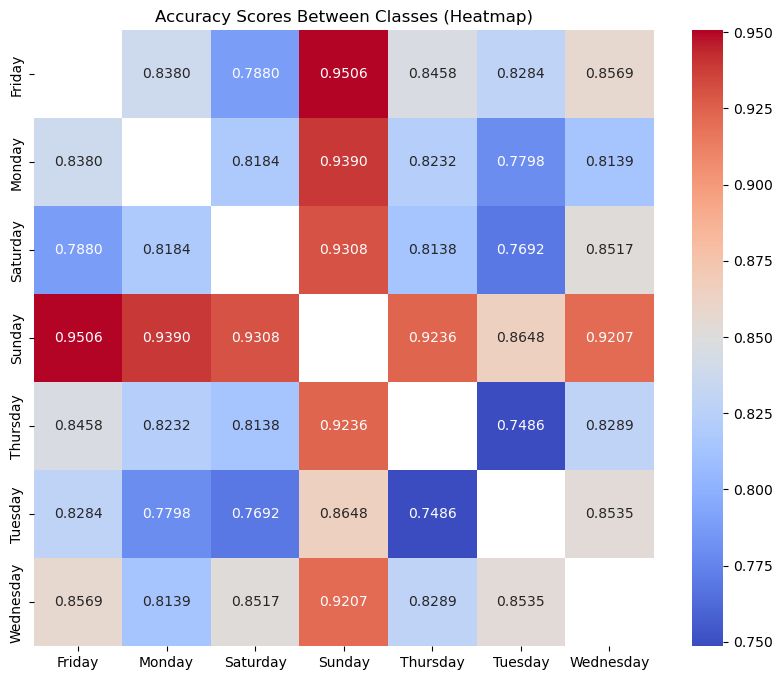

In [309]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame from the accuracy scores
accuracy_data = pd.DataFrame(columns=class_list, index=class_list)

for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    title = c1 + " vs " + c2

    # Calculate accuracy score
    accuracy = roc_auc_ovo[title]
    accuracy_data.at[c1, c2] = accuracy
    accuracy_data.at[c2, c1] = accuracy

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_data.astype(float), annot=True, fmt=".4f", cmap="coolwarm")

plt.title("Accuracy Scores Between Classes (Heatmap)")
plt.show()


## Hyperparam tuning

I used Grid search to tune hyperparameters. According to chatCPT "Grid search involves specifying a set of hyperparameter values or a range of values for each hyperparameter and then exhaustively trying all possible combinations of these values. The grid search algorithm trains and evaluates the model with each hyperparameter combination using techniques such as cross-validation."

I  just chose a reasonable range of hyperparameters to search through by consulting the scikitlearn documentation to see the range of plausibale hyperparameters and got help from ChatGPT. Below is the code the results of the hyperparameter grid search. 

As seen below the test accuracy barely changed with these hyperparameters meaning that the model is pretty much capped at around 50% accuracy for random forest classifier. 

In [313]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the hyperparameters and their possible values to search
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees in the forest
    'max_depth': [10, 20, 30, None],    # Maximum depth of the trees
    'min_samples_split': [2, 5, 10]    # Minimum samples required to split a node
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the model with the best hyperparameters
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Test Accuracy with Best Hyperparameters:", accuracy)


Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Test Accuracy with Best Hyperparameters: 0.546742209631728


## Predictions

I will use the tuned model to make predictions from out of sample data. I used the python faker module to generate fake data in another code cell and saved it to my directory. Here is what the new data looks like. I will see the test accuracy on this dataset given that this is a completely random set. I expect the model to also make random guesses as a result. 

In [407]:
data = dummify()

new_df = pd.read_csv("fakestt.csv")
new_df.head()

,trackName,msPlayed,Day,Time,artist_.Sinh,artist_.clouds,artist_0d,artist_121SELAH,artist_1K Phew,artist_1da Banton,...,artist_steezy prime,artist_sxxnt.,artist_tobi lou,artist_toni dada,artist_Øneheart,artist_سجاد حقي,artist_南征北战,artist_桑布伊,artist_달콤한꿈,trackName_length
0,FYE,150278,Thursday,14.30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,Rush,185093,Friday,6.15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,Bloody Samaritan,187000,Friday,6.20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
3,Love Don't Cost A Dime (Re-Up),147600,Friday,6.25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30
4,Comforter (feat. Ayra Starr),216000,Friday,6.30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28


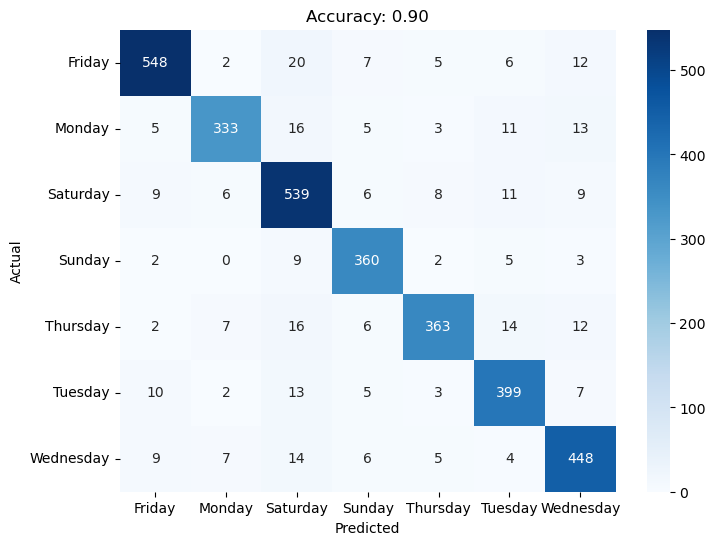

In [424]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Select the first 10 data points
sample_data = new_df

# Prepare the features
X_sample = sample_data.drop(['Day', 'trackName'], axis=1)
X_sample[['msPlayed', 'Time']] = scaler.transform(X_sample[['msPlayed', 'Time']])

# Get the true labels
y_true = sample_data['Day']

# Predict labels using the fitted model
y_pred = best_model.predict(X_sample)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Create a DataFrame to display the results
results = pd.DataFrame({'True Labels': y_true, 'Predicted Labels': y_pred})

# Create a confusion matrix (heatmap) to visualize the results
confusion_matrix = pd.crosstab(results['True Labels'], results['Predicted Labels'], rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(8, 6))

# Display accuracy in the plot title
plt.title(f'Accuracy: {accuracy:.2f}')
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()


This model performs surprisingly well with the fake data I generated. However since this is not real data these results are quite meaningless. This model should have assigned the values randomly to mirror the way the data was generated.

## Feature Importance 

Feature importance is about understanding which features contribute the most to the prediction. I used Permutation importance since I was dealing with high cardinality features. 

Permutation importance measures feature importance by evaluating how much a model's performance (e.g., accuracy or mean squared error) deteriorates when the values of a particular feature are randomly shuffled. If shuffling a feature's values leads to a significant drop in the model's performance, it suggests that the feature is important. Unfortunately with a the huge number of features I have and the permutation, this code could not run on time in my Jupyter Notebook. 


In [ ]:
# Import the permutation_importance function from the sklearn.inspection module
from sklearn.inspection import permutation_importance

# Calculate the feature importances using permutation importance
# This helps us understand the impact of each feature on the model
r = permutation_importance(rf_model, X_train, y_train, n_repeats=30, random_state=0)

# Extract the feature names from the training data
feature_names = X_train.columns

# Print the accuracy (chance level) of the model on the training data
# Note: There's a small issue, 'model' should likely be replaced with 'rf_model'
print("chance_level", model.score(X_train, y_train))

# Iterate through feature importances in descending order
for i in r.importances_mean.argsort()[::-1]:
    # Check if the feature importance is significantly different from random
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        # Print the feature name, mean importance score, and standard deviation
        print(f"{feature_names[i]:<8}"
             f"{r.importances_mean[i]:.3f}"
             f" +/- {r.importances_std[i]:.3f}")


## Executive summary 

All in all the 2 models perform quite on the spotify data, even with randomly generated data it seems to be an insightful categorization of the data.  

The logistic regression model had a test accuracy of 43% the random forest model performed with a test accuracy of 54% and an accuracy of 54% after tuning hyperparamters. The precision on different day classification was highly variable and accuracy scores on a one versus one comparison were much higher for Fridays and Sundays. With randomyl generated data the model seems to perform with high accuracy however this is cause for some alarm as the data was completely fictitious. In general the features used were highly specific to the dataset since we mapped each trackName as a separate feature. This makes the model quite low on generalizability. 

## References 
OpenAI. (2023). ChatGPT (September 25 Version) [Large language model]. https://chat.openai.com


Feature importances with a forest of trees. (2023). Scikit-Learn. https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html


Boehmke, B. (2020, February). Chapter 9 Decision Trees | Hands-On Machine Learning with R. Github.io. https://bradleyboehmke.github.io/HOML/DT.html


‌Wanderer. (2018, July 18). RandomForestClassifier instance not fitted yet. Call “fit” with appropriate arguments before using this method. Stack Overflow. https://stackoverflow.com/questions/51397611/randomforestclassifier-instance-not-fitted-yet-call-fit-with-appropriate-argu


‌Wanderer. (2018, July 18). RandomForestClassifier instance not fitted yet. Call “fit” with appropriate arguments before using this method. Stack Overflow. https://stackoverflow.com/questions/51397611/randomforestclassifier-instance-not-fitted-yet-call-fit-with-appropriate-argu


‌manishkc06. (2020, July 31). multi-class-logistic-regression: Beginner’s Guide. Kaggle.com; Kaggle. https://www.kaggle.com/code/manishkc06/multi-class-logistic-regression-beginner-s-guide


‌Sidharth. (2022, March 29). Multinomial Logistic Regression: Defintion, Math, and Implementation. Pycodemates.com; PyCodeMates. https://www.pycodemates.com/2022/03/multinomial-logistic-regression-definition-math-and-implementation.html


‌Sidharth. (2022, March 29). Multinomial Logistic Regression: Defintion, Math, and Implementation. Pycodemates.com; PyCodeMates. https://www.pycodemates.com/2022/03/multinomial-logistic-regression-definition-math-and-implementation.html

‌